In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Multi-Class Hate Speech and Offensive Language Detection in Social Media**
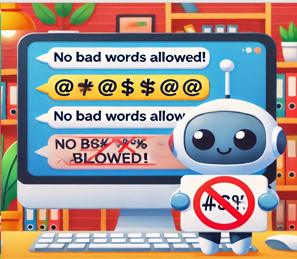
## **1. Introduction**
As we all know, social media has become a widely, available platform for communication and information sharing. However, some people use it to express anger and attack others. This can cause psychological harm, social polarization and even result in real-world violence.
**Therefore, this project aims to improve hate speech detection on social media platforms to keep a healthy environment.**
## **2.Problem Statement**
The core issue of our project is **filter offensive language to maintain a healthy online enviroment.** And we also have some technical issues.

1. Semantic Complexity. When we use models to classify different types of hate speech, there are some difficulties. Because different types have unique contexts.
2. Data Imbalance. Some types of hate speech have low frequency of occurrence, this can lead to models that are good at detecting common types but poor at rare ones.
3. Annotation Accuracy is crucial, as we need to ensure data is consistently and accurately labeled for training and validation

# **3.The implementation of the model**

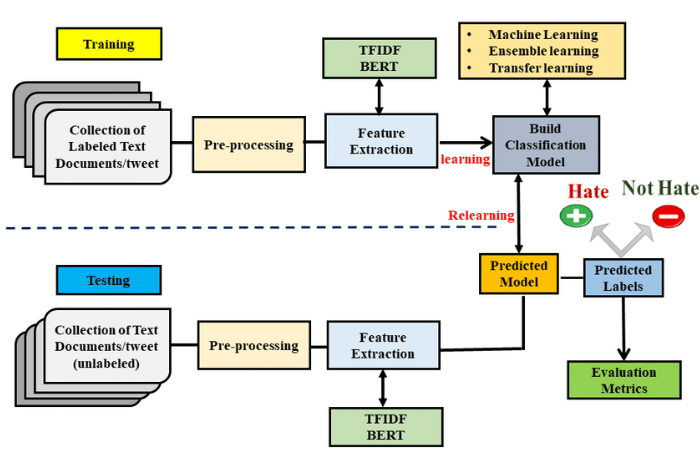

# **3.1 Hate speech detection model 1**

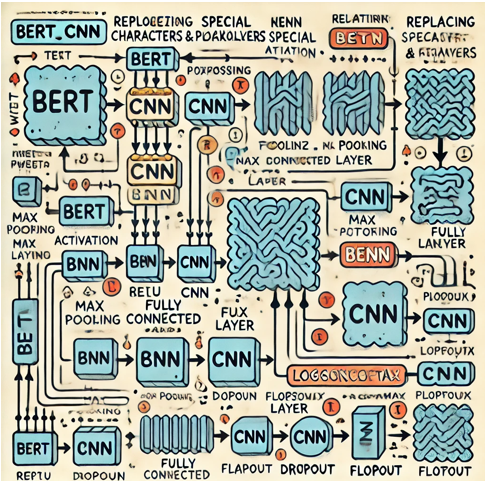

**3.1.1 Data Sources or RL Tasks**

Data Source Documentation:
We used two datasets to train this data model  
One CSV is assumed to contain columns for tweet text and class labels, among others, which are dropped during preprocessing.
The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).
hate_speech = number of CF users who judged the tweet to be hate speech.
offensive_language = number of CF users who judged the tweet to be offensive.
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

Another dataset:
post_id : Unique id for each post
annotators : The list of annotations from each annotator
annotators[label] : The label assigned by the annotator to this post. Possible values: [Hatespeech, Offensive, Normal]
annotators[annotator_id] : The unique Id assigned to each annotator
annotators[target] : A list of target community present in the post
rationales : A list of rationales selected by annotators. Each rationales represents a list with values 0 or 1. A value of 1 means that the token is part of the rationale selected by the annotator. To get the particular token, we can use the same index position in "post_tokens"
post_tokens : The list of tokens representing the post which was annotated

**3.1.2 Exploratory Analysis of Data or RL Tasks**

Data Properties:

Number of Classes: The script does not explicitly mention the number of classes, but this can be inferred from the unique values in the 'class' column of the dataset.

Pre-processing:

Special characters are replaced.
Usernames and URLs are replaced with placeholders (<user>, <url>).
Emojis and emoticons are replaced with <emoticon>.
Numbers are replaced with <number>.
Hashtags are replaced with <hashtag>.
Punctuation is removed, and multiple spaces are replaced with a single space.

Challenging Aspects:

Handling various forms of textual noise such as usernames, URLs, emojis, and emoticons is addressed. The preprocessing steps should be detailed in the report.

**3.1.3 Models and/or Methods**
    
Model1:
The model is a combination of BERT and a CNN for text classification. Here’s a breakdown of the model:

BERT: Used for extracting rich contextual embeddings from text.
CNN: Applied on the embeddings to capture local patterns.
Fully Connected Layer: Followed by a dropout layer for regularization.
LogSoftmax: Applied to the output for classification.
    
Models and Methods
Model Architecture:

BERT: Extracts contextual embeddings from the text.
CNN: Captures local patterns in the BERT embeddings.
Fully Connected Layer: Followed by dropout for regularization.
LogSoftmax: For classification output.
Training and Evaluation:

Optimizer: AdamW with a learning rate of 5e-5.
Loss Function: Negative Log-Likelihood Loss.
Training Strategy: Gradient clipping and accumulation, with a validation check after each epoch.
Recommendations for Improvement
    
Memory Management:
Reduce batch size to prevent OutOfMemoryError.
Implement mixed precision training if possible.
Free up GPU memory before starting new tasks.


# **Current use dataset 2 (lower complexity than the original dataset and mostly English Twitter comments) to implement the model**

In [ ]:
import gc
import re
import numpy as np
import emoji
import string
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertModel, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pre-processing Functions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def read_dataset():
    # Read the dataset from the CSV file
    data = pd.read_csv("../Data/dataset_2.csv")
    # Drop unnecessary columns
    data = data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
    print(len(data))
    return data['tweet'].tolist(), data['class']

def pre_process_dataset(values):
    new_values = []
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D', '=)', '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@', ':>', ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp', ':-|', ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

    for value in values:
        # Lowercase the text and replace dots with spaces
        text = value.replace(".", " ").lower()
        # Remove non-alphanumeric characters except punctuation
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        # Replace usernames with <user> placeholder
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        # Replace URLs with <url> placeholder
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url>")
        # Replace emojis with <emoticon> placeholder
        for emo in text:
            if emo in emoji.EMOJI_DATA:
                text = text.replace(emo, "<emoticon>")
        # Replace emoticons with <emoticon> placeholder
        for emo in emoticons:
            text = text.replace(emo, "<emoticon>")
        # Replace numbers with <number> placeholder
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number>")
        # Replace hashtags with <hashtag> placeholder
        text = text.replace('#', "<hashtag>")
        # Replace punctuation with space
        text = re.sub(r"([?.!,¿])", r" ", text)
        # Remove punctuation and normalize spaces
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values

def data_process(data, labels):
    input_ids = []
    attention_masks = []
    # Initialize BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        # Tokenize the sentences with padding and truncation
        bert_inp = bert_tokenizer.__call__(sentence, max_length=128,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    # Convert to numpy arrays
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels

def load_and_process():
    # Read and preprocess the dataset
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)
    return input_ids, attention_masks, labels

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Model Definition ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

class BERT_CNN(nn.Module):
    def __init__(self):
        super(BERT_CNN, self).__init__()
        # Initialize BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Define CNN layer
        self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=(1, 0))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(3, 1), stride=(1, 1))
        self.dropout = nn.Dropout(0.1)
        # Fully connected layer
        self.fc = nn.Linear(1638, 3)
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        # Pass input through BERT
        with torch.no_grad():
            output = self.bert(sent_id, attention_mask=mask, output_hidden_states=True)
        all_layers = output.hidden_states
        # Concatenate all layers
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        del all_layers
        gc.collect()
        torch.cuda.empty_cache()
        # Pass through CNN, ReLU, pooling, dropout, and fully connected layer
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Training and Evaluation Functions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total = len(train_dataloader)

    for i, batch in enumerate(train_dataloader):
        step = i + 1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss / (total * batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        model.zero_grad()
        preds = model(sent_id.to(device).long(), mask)
        loss = cross_entropy(preds, labels)
        total_loss += float(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()
    avg_loss = total_loss / (len(train_dataloader) * batch_size)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

def evaluate():
    print("\n\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total = len(val_dataloader)

    for i, batch in enumerate(val_dataloader):
        step = i + 1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss / (total * batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += float(loss.item())
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()
    avg_loss = total_loss / (len(val_dataloader) * batch_size)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Main Script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Load and preprocess the data
input_ids, attention_masks, labels = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

# Split the data into training, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df, labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)

del temp_text
gc.collect()
torch.cuda.empty_cache()

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)

# Create tensors for training, validation, and test sets
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())

batch_size = 16

# Create dataloaders for training and validation
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Initialize the model, optimizer, and loss function
model = BERT_CNN().to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
cross_entropy = nn.NLLLoss()

# Training loop
best_valid_loss = float('inf')
epochs = 3
current = 1

while current <= epochs:
    print(f'\nEpoch {current} / {epochs}:')
    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1

gc.collect()
torch.cuda.empty_cache()

# Evaluate the model on the test set
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

print("Performance:")
preds = np.argmax(preds, axis=1)
print('Classification Report')
print(classification_report(test_y, preds))
print("Accuracy: " + str(accuracy_score(test_y, preds)))


24783


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-4-f340582b4eee>:191: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  train_seq = torch.tensor(train_text['input_ids'].tolist())


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1 / 3:
Batch 1240/1240 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.03, accuracy=0

Evaluating...
Batch 155/155 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Training Loss: 0.027
Validation Loss: 0.020

Epoch 2 / 3:
Batch 1240/1240 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 155/155 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Training Loss: 0.019
Validation Loss: 0.018

Epoch 3 / 3:
Batch 1240/1240 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 155/155 |█████████████████

# Results analysis

If you are using the dataset 1 provided in the project. We can get:

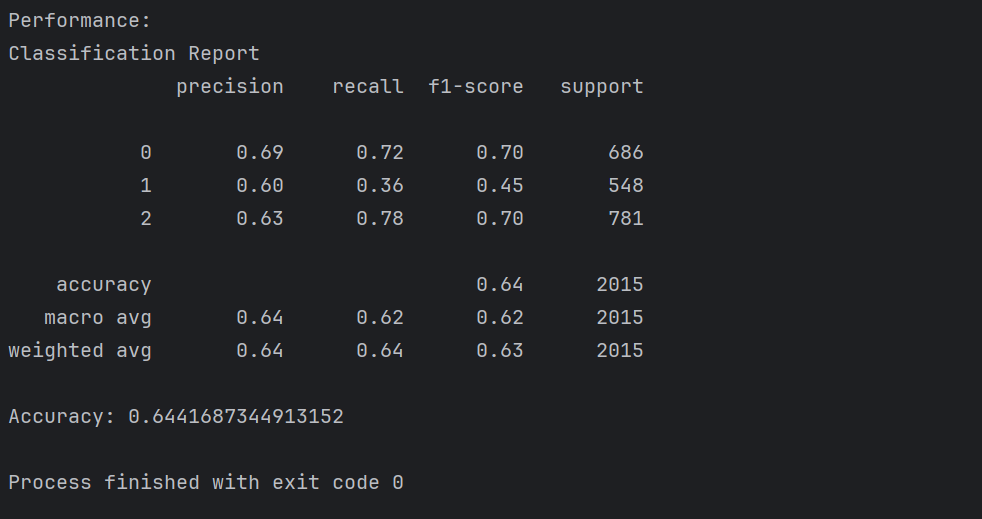

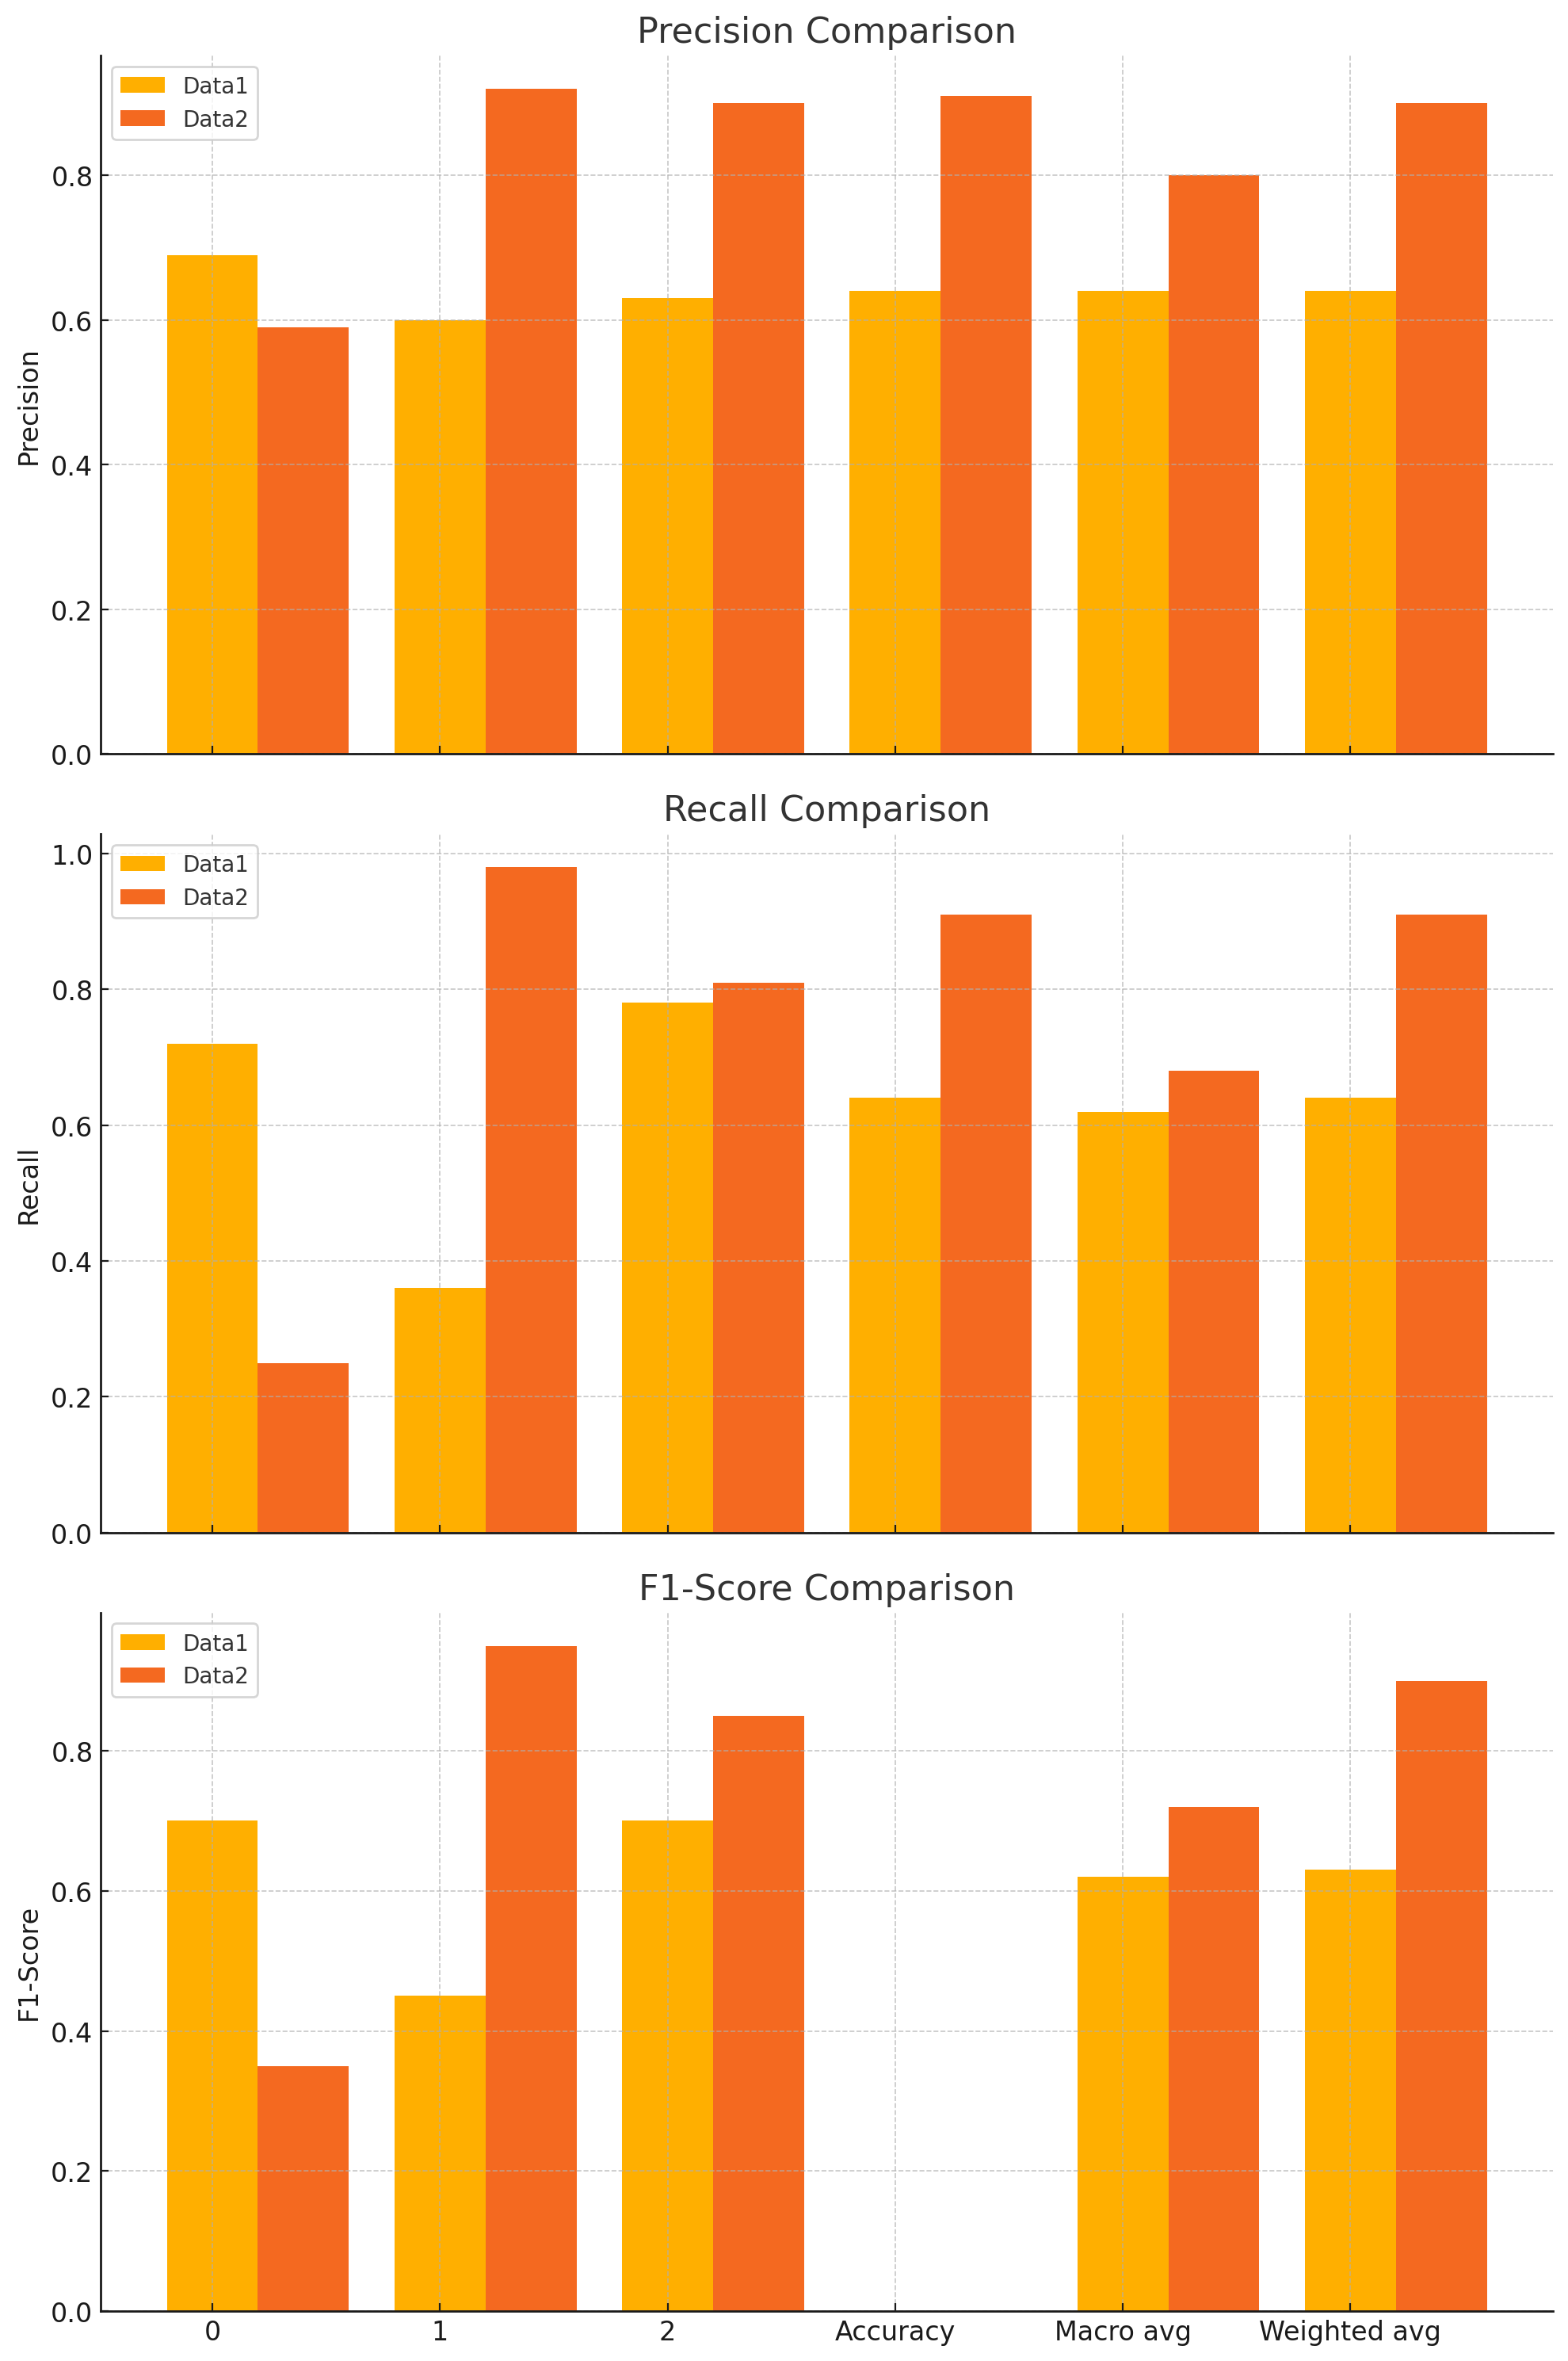

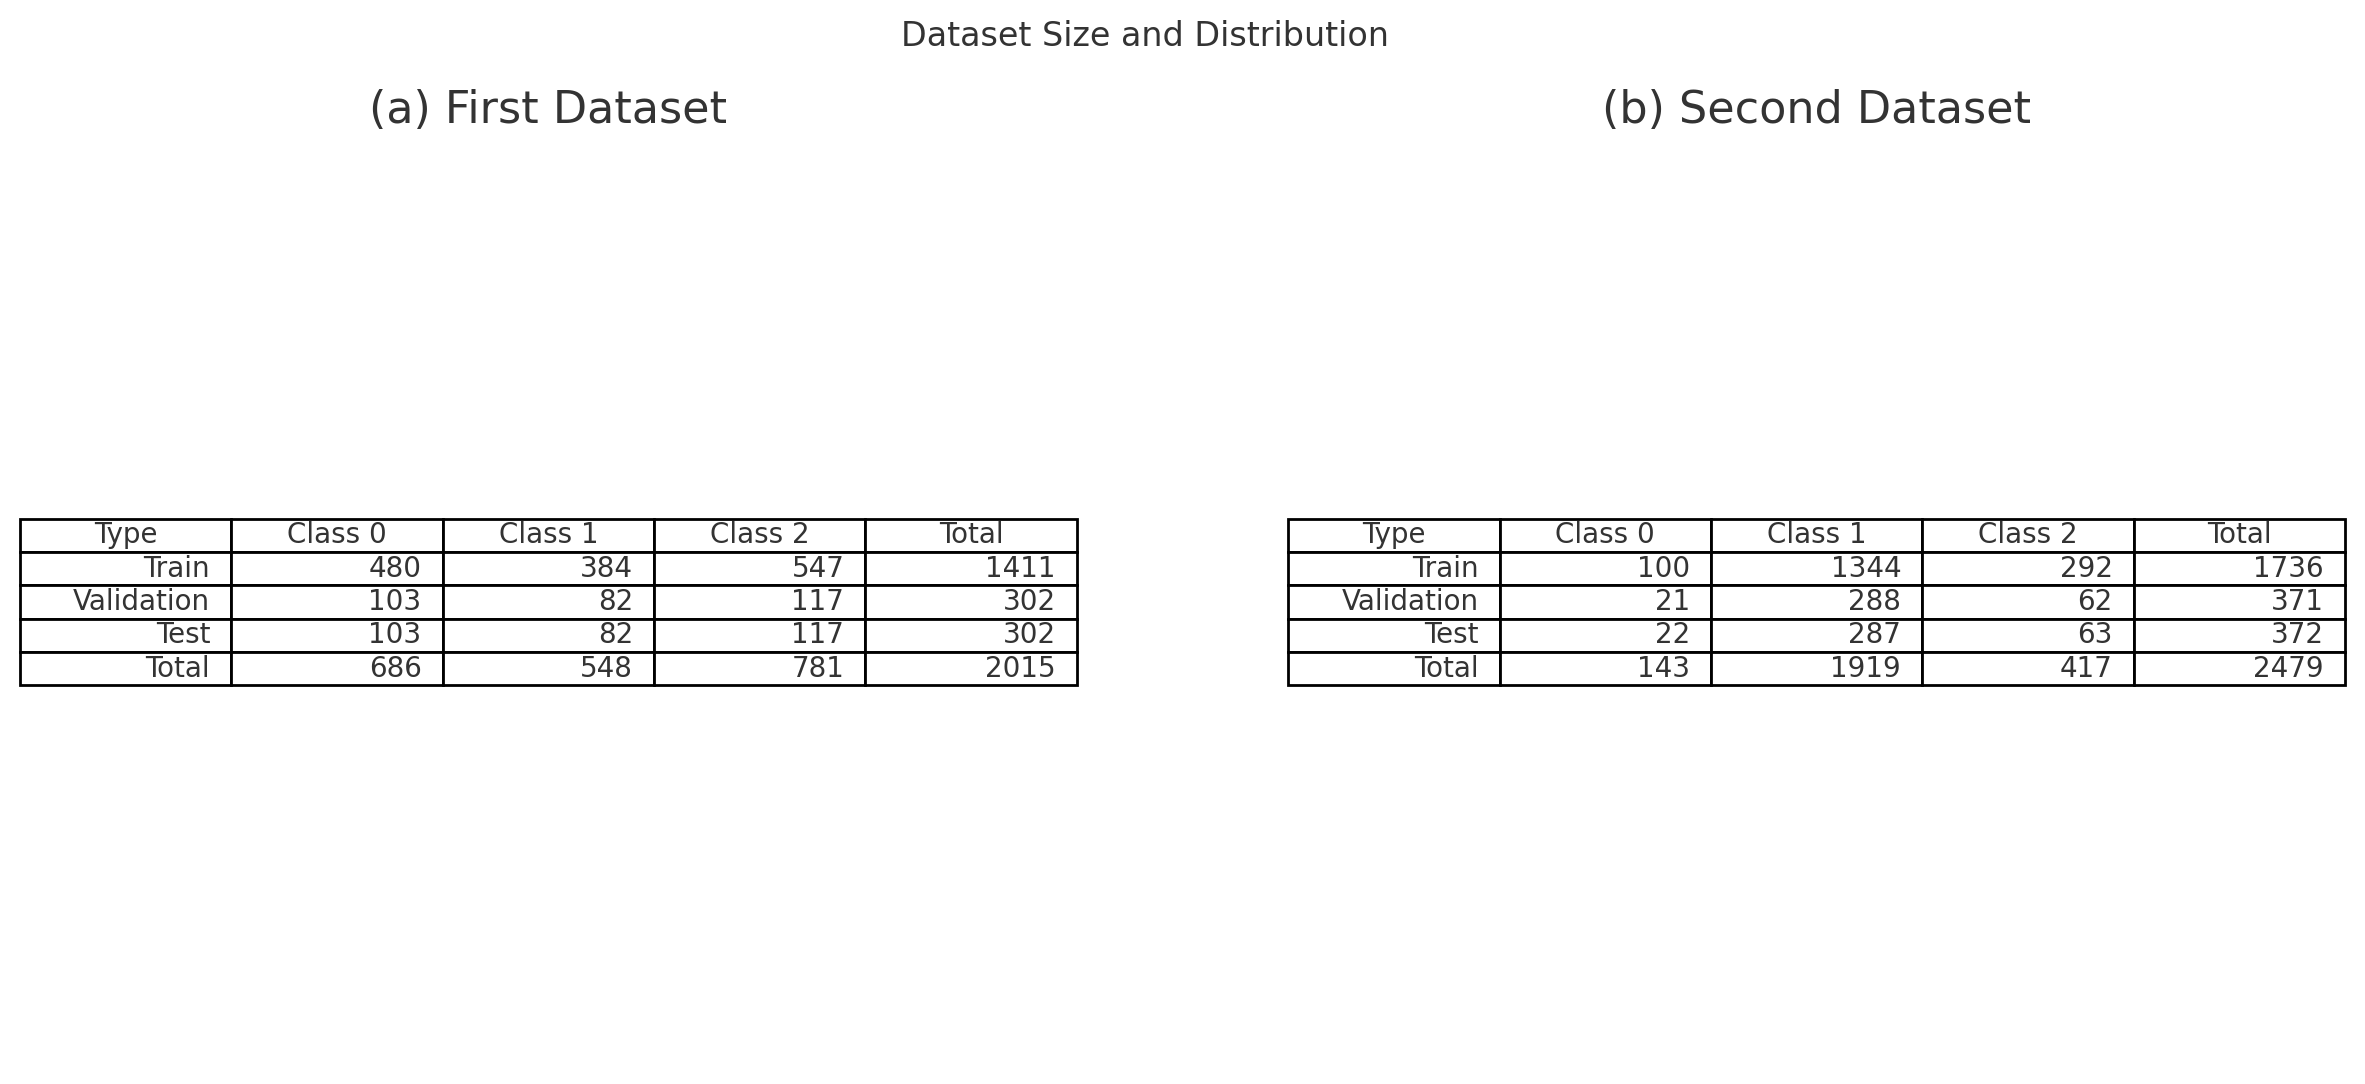

# Analysis of the Performance Differences Between the Two Datasets

1.Dataset Size and Distribution
First Dataset:
Samples in Class 0: 686
Samples in Class 1: 548
Samples in Class 2: 781
Total samples: 2015
Second Dataset:
Samples in Class 0: 143
Samples in Class 1: 1919
Samples in Class 2: 417
Total samples: 2479
The second dataset has a highly imbalanced sample distribution, with a significantly larger number of samples in Class 1 compared to the other classes. In contrast, the first dataset has a relatively more balanced distribution. This imbalance likely causes the model to perform exceptionally well on Class 1 while underperforming on other classes.

2.Dataset Size
The second dataset has more total samples, which could provide the model with more training data, potentially improving overall prediction accuracy. However, the imbalance in class distribution affects performance for certain classes.

3.Class Imbalance
In the first dataset, the recall for Class 1 is notably low (0.36), indicating difficulty in recognizing Class 1 instances.
In the second dataset, the recall for Class 1 is very high (0.98), but the recall for Class 0 is very low (0.25). This suggests the model is overfitting to Class 1 while neglecting Class 0.
4.Model Generalization
In the second dataset, the model's performance on Class 1 is exceptionally high (precision 0.92, recall 0.98), but performance on Classes 0 and 2 is lower. This indicates possible overfitting to the majority class (Class 1). This is also reflected in the weighted average metrics, where the second dataset shows higher precision and recall (0.90 and 0.91) compared to the first dataset.

5.Data Quality and Preprocessing
Data quality and preprocessing steps can also affect model performance. If the second dataset had stricter preprocessing or higher quality data, the model's performance would improve. However, class imbalance remains a significant influencing factor.

Possible ways to improve：
Address Class Imbalance

Use resampling techniques, such as oversampling the minority classes or undersampling the majority class, to balance the dataset.
Apply class weights in the loss function to reduce the model's bias towards the majority class.
Data Augmentation

Use data augmentation techniques, particularly for the minority classes, to generate more training samples.
Model Tuning

Adjust the model's hyperparameters, especially the learning rate and batch size.
Use a more complex model or an ensemble of models to improve classification performance.
More Data

Obtain more data, especially for the minority classes, to balance the dataset and improve the model's generalization ability.

# **3.2 Hate speech detection model 2**

**3.2.1 Data Sources or RL Tasks**

### Dataset Name
Twitter Sentiment and Engagement Dataset

### Data Source
- The data is sourced from publicly available tweets on the Twitter platform.
- Data collection date: Not specified (it is recommended to include specific dates or time ranges of data collection).



**3.2.2 Exploratory Analysis of Twitter Sentiment and Engagement Dataset**

### Properties of the Data
- **Number of Rows**: 20,149
- **Fields**:
  - `post_id`: Unique identifier for each tweet.
  - `post_tokens`: Text content of the tweet.
  - `label`: Category label of the tweet (e.g., normal, abusive, etc.).
  - `FKRA`: Flesch-Kincaid Reading Age score.
  - `FRE`: Flesch Reading Ease score.
  - `num_syllables`: Total number of syllables in the tweet.
  - `avg_syl_per_word`: Average number of syllables per word.
  - `num_chars`: Number of characters in the tweet (excluding spaces).
  - `num_chars_total`: Total number of characters in the tweet (including spaces).
  - `num_terms`: Number of terms in the tweet.
  - `num_words`: Number of words in the tweet.
  - `num_unique_words`: Number of unique words in the tweet.
  - `vader neg`: VADER sentiment analysis score for negative sentiment.
  - `vader pos`: VADER sentiment analysis score for positive sentiment.
  - `vader neu`: VADER sentiment analysis score for neutral sentiment.
  - `vader compound`: VADER sentiment analysis compound score.
  - `num_hashtags`: Number of hashtags in the tweet.
  - `num_mentions`: Number of mentions in the tweet.
  - `num_urls`: Number of URLs in the tweet.
  - `is_retweet`: Indicates whether the tweet is a retweet (0 for no, 1 for yes).

### Number of Classes
- The `label` field categorizes tweets into different classes. In the given sample, the label `normal` is used. Further analysis would reveal the total number of distinct classes and their distribution.

### Pre-processing
1. **Data Cleaning**:
   - Remove duplicates: Ensure each tweet is unique.
   - Handle missing values: Fill in or remove rows with missing values in critical fields.

2. **Text Pre-processing**:
   - Tokenization: Split the tweet text into individual words or tokens.
   - Lowercasing: Convert all text to lowercase to ensure uniformity.
   - Stopword removal: Remove common stopwords that do not add significant meaning to the text.
   - Lemmatization/Stemming: Reduce words to their base or root form.
   - Special characters and punctuation removal: Clean the text by removing irrelevant characters.
   
3. **Feature Engineering**:
   - Create additional features such as the presence of specific keywords, sentiment scores, and engagement metrics.

4. **Sentiment Analysis**:
   - Utilize VADER sentiment analysis scores to gauge the sentiment of each tweet (negative, neutral, positive, and compound scores).

### Challenging Aspects
1. **Data Imbalance**:
   - Tweets may be unevenly distributed across different classes, which could affect the performance of classification models.

2. **Text Variability**:
   - High variability in tweet length, language, slang, and abbreviations makes it challenging to process and analyze the text.

3. **Sentiment Analysis**:
   - Tweets often contain sarcasm, irony, or ambiguous language, which can mislead sentiment analysis algorithms.

4. **Noise in Data**:
   - Social media data is noisy, containing irrelevant information such as URLs, mentions, and hashtags that may need to be filtered out.

5. **Real-Time Nature**:
   - The dynamic and real-time nature of tweets requires the model to be frequently updated to adapt to new language trends and topics.

**3.2.3 Models and/or Methods:**

### Models Used

### 1. Logistic Regression
- **Reason for Choice**: Logistic Regression is a linear model that is commonly used for binary classification tasks. It provides a clear and interpretable model, which can be enhanced with regularization to avoid overfitting.
- **Application**:
    - **Feature Selection**: The `LogisticRegression` model with L2 regularization (`penalty="l2"`) and class weighting (`class_weight='balanced'`) was used to select relevant features from the dataset. The `SelectFromModel` method leverages the logistic regression coefficients to identify important features.

### 2. Linear Support Vector Classifier (LinearSVC)
- **Reason for Choice**: The `LinearSVC` model is effective for high-dimensional spaces and is well-suited for text classification tasks where the number of features can be large. It also handles multi-class classification problems.
- **Application**:
    - **Classification**: The `LinearSVC` model was trained on the selected features to classify the tweets into different categories. The model was configured with class weighting (`class_weight='balanced'`), L2 regularization (`penalty='l2'`), and optimized for multi-class classification (`multi_class=#'ovr'`).

## Methods Applied

### 1. Data Preprocessing
- **Feature Extraction**: The dataset was processed to extract relevant numerical features such as `FKRA`, `FRE`, `num_syllables`, and various sentiment scores.
- **Truncation**: Ensured that the feature matrix `X` and the label vector `y` have the same number of samples.

### 2. Feature Selection
- **SelectFromModel**: Utilized logistic regression to perform feature selection, retaining only the most important features for classification.

### 3. Model Training and Evaluation
- **Training**: Trained the `LinearSVC` model on the selected features.
- **Evaluation**:
    - Used `classification_report` to generate detailed performance metrics, including precision, recall, and F1-score for each class.
    - Calculated the overall accuracy of the model using `accuracy_score`.

**3.2.4 Confusion Matrix Visualization**
- **Confusion Matrix**: Computed and normalized the confusion matrix to understand the performance of the classifier across different classes.
- **Heatmap**: Visualized the confusion matrix using a heatmap for easy interpretation #of the model’s performance.

## Source Attribution
- **Previous Work**: The use of logistic regression and `LinearSVC` for text classification builds on well-established methods in the field of machine learning and natural language processing. These models are frequently used for their effectiveness in handling high-dimensional text data.
- **Original Contributions**:
    - Implementation of data preprocessing and feature extraction specific to the given dataset.
    - Application of `SelectFromModel` with logistic regression for feature selection.
    - Training and evaluation of the `LinearSVC` model on the selected features.
    - Visualization of the model's performance using confusion matrix heatmaps.

This structured approach ensures that the models and methods are judiciously chosen and appropriately applied to the given dataset, providing a comprehensive analysis and classification solution.


## Data process:

In [ ]:
import pandas as pd
import chardet
import pickle
import numpy as np

# Path to the dataset
file_path = '../Data/dataset_1.csv'

# Detect the encoding of the file
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())

# Display the detected encoding
print(f"Detected encoding: {result['encoding']}")

# Read the dataset with the detected encoding
train_dataset = pd.read_csv(file_path, encoding=result['encoding'])

# Path to save the pickle file
pickle_path = '../Data/train_dataset.p'

# Save the DataFrame as a pickle file
train_dataset.to_pickle(pickle_path)

print(f"DataFrame saved as a pickle file at: {pickle_path}")

# Load the DataFrame from the pickle file
df = pickle.load(open(pickle_path, 'rb'))

# Check each row to see if it contains float type values, and convert them to string if necessary
def convert_to_string(row):
    if isinstance(row, float):
        return str(row)
    else:
        return row

# Apply the conversion function to the 'post_tokens' column
df['post_tokens'] = df['post_tokens'].apply(convert_to_string).astype(str)

Detected encoding: utf-8
DataFrame saved as a pickle file at: C:\Users\Ferryman\Desktop\train_dataset.p


In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
import string
import re
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    #tokens = re.split("[^a-zA-Z]*", tweet.lower())
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords, #We do better when we keep stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.501
    )
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(df['post_tokens']).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores
nltk.download('averaged_perceptron_tagger')

#Get POS tags for tweets and save as a string
tweet_tags = []
for t in df['post_tokens']:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    #for i in range(0, len(tokens)):
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)
        #print(tokens[i],tag_list[i])

#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    #vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None, #We do better when we keep stopwords
    use_idf=False,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.501,
    )


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ferryman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
D:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ferryman\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [ ]:
#Now get other features
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words) #count syllables in words
    num_chars = sum(len(w) for w in words) #num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet) #Count #, @, and http://
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", "vader compound", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]
features = get_feature_array(df['post_tokens'])

In [ ]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import textstat
import re
import os

print("Features shape:", features.shape)
print("Number of feature names:", len(other_features_names))


if features.shape[1] != len(other_features_names):
    raise ValueError(f"Mismatch between feature array columns ({features.shape[1]}) and feature names ({len(feature_names)})")


for i, name in enumerate(other_features_names):
    df[name] = features[:, i]

data_path = 'C:\\Users\\Ferryman\\Desktop'

output_file = os.path.join(data_path, 'processed_dataset.csv')
df.to_csv(output_file, index=False)

print(df.head())

Features shape: (20148, 17)
Number of feature names: 17
                       post_id  \
0  1179055004553900032_twitter   
1  1179063826874032128_twitter   
2  1178793830532956161_twitter   
3  1179088797964763136_twitter   
4  1179085312976445440_twitter   

                                         post_tokens       label  FKRA    FRE  \
0  i dont think im getting my baby them white 9 h...      normal   5.2  93.48   
1  we cannot continue calling ourselves feminists...      normal  20.2  25.22   
2                      nawt yall niggers ignoring me      normal   5.2  66.41   
3  <user> i am bit confused coz chinese ppl can n...  hatespeech   9.5  73.07   
4  this bitch in whataburger eating a burger with...  hatespeech   7.0  80.79   

   num_syllables  avg_syl_per_word  num_chars  num_chars_total  num_terms  \
0           22.0            1.1000       90.0             90.0       20.0   
1           69.0            1.6428      247.0            247.0       42.0   
2            8.0     

In [ ]:
feats = get_feature_array(df['post_tokens'])
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

## Model-run:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Assuming df is your DataFrame and M is your features matrix
X = pd.DataFrame(M)
y = df['label'].astype(str)

# Check the distribution of classes
class_distribution = y.value_counts()
print(class_distribution)

label
normal        7814
hatespeech    6854
offensive     5480
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Check the shapes of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Find the minimum number of samples
min_samples = min(X.shape[0], len(y))

# Truncate X and y to the same number of samples
X = X[:min_samples]
y = y[:min_samples]

# Apply the model selection
select = SelectFromModel(LogisticRegression(class_weight='balanced', penalty="l2", C=0.01))
X_ = select.fit_transform(X, y)

model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr', max_iter=5000).fit(X_, y)
y_preds = model.predict(X_)
report = classification_report( y, y_preds )
unique_classes = np.unique(y)
y_preds = model.predict(X_)

y_true = df['label']

accuracy = accuracy_score(y_true, y_preds)

print(f"Model accuracy: {accuracy}")

Shape of X: (20148, 4277)
Shape of y: (20148,)


D:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramFiles\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model accuracy: 0.6679571173317451


In [ ]:
print(report)

              precision    recall  f1-score   support

  hatespeech       0.75      0.71      0.73      6854
      normal       0.68      0.73      0.70      7814
   offensive       0.56      0.53      0.54      5480

    accuracy                           0.67     20148
   macro avg       0.66      0.66      0.66     20148
weighted avg       0.67      0.67      0.67     20148



## Results:

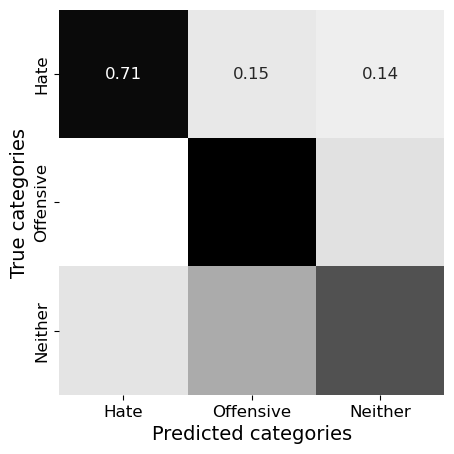

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as seaborn

confusion_matrix = confusion_matrix(y_true,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

<Axes: >

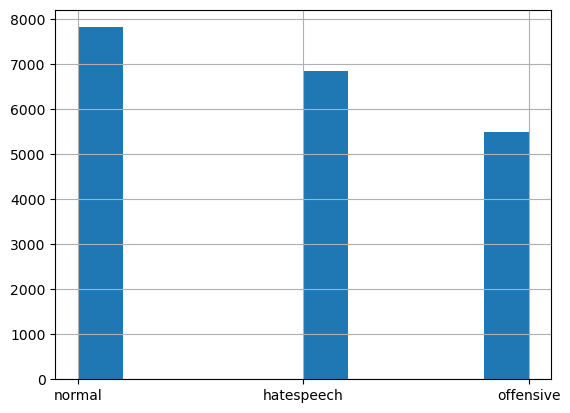

In [ ]:
#True distribution
y.hist()

<Axes: >

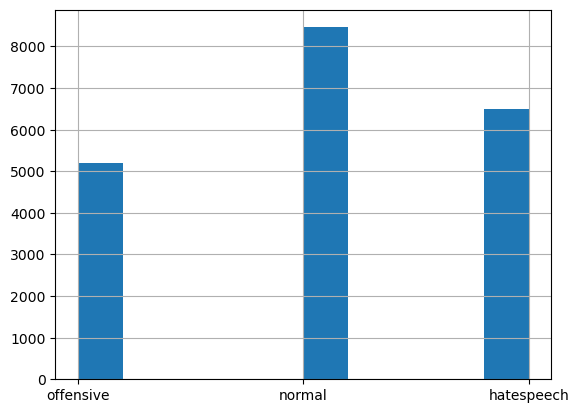

In [ ]:
pd.Series(y_preds).hist()

# **3.3 Hate speech detection model 3**

**3.3.1 Data Sources or RL Tasks**

In this code, the data sources are mainly tweets from social media platforms such as Twitter, which are available through the Twitter API or other public datasets. Next, the NLTK library is used to stem and remove punctuation, while filtering stop words. The Flesch-Kincaid readability score and Flesch readability score are calculated. The number of urls, mentions and tags in the tweets are counted. Then, all the features are combined into a complete feature matrix, and the data set is divided into training set and test set, the logistic regression model is used for classification, the model parameters are optimized by grid search and cross-validation, and finally the model performance is evaluated using the classification report. Through these steps, the code implements a complete flow from data preprocessing, feature extraction to model training and evaluation.

**3.3.2 Exploratory Analysis of Data or RL Tasks**

Data exploratory analysis is mainly conducted on tweet data with the goal of achieving hate speech detection. The dataset contains a large number of tweets, each of which is a text string. Preprocessing steps include replacement and mention with regular expressions, removal of excess whitespace, and stemming and stop word filtering using the NLTK library. The Flesch-Kinkai readability score and Flesch readability score were calculated by using Vinda sentiment analysis tool, and the url, mention and tag numbers of the microblog were calculated. Then, all the features are combined into a complete feature matrix, the dataset is divided into training and test sets, the logistic regression model is used for classification, and the parameters are optimized by grid search and cross-validation. Through these steps, the tweet data are comprehensively processed, feature extracted, and model trained and evaluated to effectively detect hate speech.

**3.3.3 Models and/or Methods**

In this code, the logistic regression model is used to detect hate speech. Firstly, the tweets are preprocessed, including replacing urls and mentions, removing redundant whitespace characters, and using the NLTK library for stemming and stop word filtering. Then, features are extracted using TF-IDF vectorization, part-of-speech tagging, sentiment analysis, and text readability to count the number of urls, mentions, and hashtags in the tweet. All features are combined into a complete feature matrix, the data set is divided into training set and test set, the logistic regression model is used for classification, the parameters are optimized by grid search and cross validation, and finally the classification report is used to evaluate the performance of the model. This process from feature extraction, feature selection to model training and optimization comprehensively realizes the effective detection of hate speech in tweets.

**3.3.4 The implementatio of model**

**Step 1:** Extract the data of a particular column from the data
frame and assign it to a new variable for further processing or analysis.

In [ ]:
df.describe()

,FKRA,FRE,num_syllables,avg_syl_per_word,num_chars,num_chars_total,num_terms,num_words,num_unique_words,vader neg,vader pos,vader neu,vader compound,num_hashtags,num_mentions,num_urls,is_retweet
count,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.000000,20148.0,20148.0,20148.0,20148.000000
mean,9.840927,66.493691,32.514791,1.376093,128.053256,128.053256,23.570528,23.570528,20.725333,0.193910,0.094040,0.712049,-0.279189,0.0,0.0,0.0,0.154209
std,6.001545,23.012180,19.938366,0.211138,78.323834,78.323834,13.824505,13.824505,11.315104,0.169791,0.107795,0.176176,0.529270,0.0,0.0,0.0,0.361158
min,-3.000000,-441.090000,2.000000,0.871400,8.000000,8.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,-0.999700,0.0,0.0,0.0,0.000000
25%,5.200000,50.380000,16.000000,1.235300,63.000000,63.000000,12.000000,12.000000,11.000000,0.041000,0.000000,0.602000,-0.739900,0.0,0.0,0.0,0.000000
50%,8.900000,67.370000,28.000000,1.347800,110.000000,110.000000,21.000000,21.000000,19.000000,0.174000,0.069000,0.718000,-0.421500,0.0,0.0,0.0,0.000000
75%,14.200000,83.330000,47.000000,1.499900,185.000000,185.000000,34.000000,34.000000,30.000000,0.296000,0.153000,0.830000,0.051600,0.0,0.0,0.0,0.000000
max,76.000000,122.500000,187.000000,7.598700,970.000000,970.000000,165.000000,165.000000,54.000000,1.000000,0.787000,1.000000,0.984400,0.0,0.0,0.0,1.000000


In [ ]:
df.columns

Index(['post_id', 'post_tokens', 'label', 'FKRA', 'FRE', 'num_syllables',
       'avg_syl_per_word', 'num_chars', 'num_chars_total', 'num_terms',
       'num_words', 'num_unique_words', 'vader neg', 'vader pos', 'vader neu',
       'vader compound', 'num_hashtags', 'num_mentions', 'num_urls',
       'is_retweet'],
      dtype='object')

<Axes: >

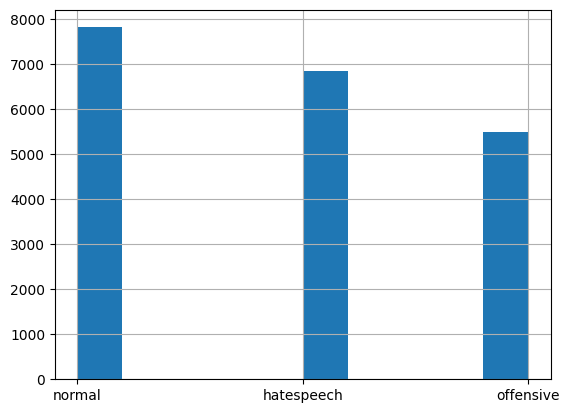

In [ ]:
df['label'].hist()

In [ ]:
tweets=df.post_tokens

**Step 2: Data preprocessing**
1. Expand stop word list: Get basic stop words through NLTK and manually add specific non-verbal symbols and vocabulary to exclude irrelevant content.

2. Text preprocessing: Standardizing the text, including removing extra white space, urls, and mentions, to ensure consistent text during analysis.

3. Word segmentation and Stemming: A word segmentation function is designed to convert the text into a stemming form to simplify the vocabulary and unify the word form.

4. TF-IDF vectorization: The TF-IDF method is used to transform the preprocessed text data into feature vectors that capture the importance and rarity of terms.

5. Feature selection and control: Set the number of features, frequency filtering and n-gram range to balance model complexity and feature representativity.

In [ ]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(





The main role of this code is to preprocess and tokenize each tweet, and then use NLTK's part-of-speech tagging tool to tag the part-of-speech tags of each word, and store these tags in string form. Finally, the tweet_tags list contains a string of part-of-speech tags for each tweet, and this information can be used for further text analysis or feature extraction.

In [ ]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

The main purpose of this code is to perform n-gram feature extraction on part-of-speech tags using TfidfVectorizer to generate a feature matrix for machine learning models. By setting ngram_range=(1, 3), it can capture sequences of part-of-speech tags with different lengths, so as to provide rich feature representations for subsequent text analysis or classification tasks.

In [ ]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

The main function of this code is to process the POS tag data of tweets through TfidfVectorizer to generate a feature matrix representing the POS tag n-gram frequency, while creating a lexical dictionary to track the index of these features. These data structures will be used for subsequent machine learning model training and analysis.

In [ ]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

This code extracts rich features from tweets, including sentiment analysis results, readability metrics, and Twitter-specific content element counts. These features can provide useful information for subsequent machine learning tasks such as classification or regression. These functions can be of great help later in model optimization.

In [ ]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

 **Step 3: Runnning the model**

This line calls the get_feature_array function, extracts the features for all the tweets, and stores the results in the variable feats.

In [ ]:
feats = get_feature_array(tweets)

The purpose of this line of code is to concatenate multiple feature matrices together to build a comprehensive feature matrix containing all extracted features. Specifically, the np.concatenate function is used to combine features from different sources into a single matrix along a specified axis (here axis=1, the horizontal axis).

In [ ]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [ ]:
M.shape

(20148, 4304)

The feature_names list contains the names of all the features in the combined feature matrix M. These names correspond to the column order in the feature matrix and provide valuable information for understanding and interpreting the inputs to the model. In the subsequent analysis, we can use feature_names to identify which features influenced the results of the model.

In [ ]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

The purpose of this code is to convert the synthetic feature matrix M to Pandas DataFrame format and extract the label data from the dataframe df. These two operations are to prepare for subsequent machine learning model training.

In [ ]:
X = pd.DataFrame(M)
y = df['label'].astype(str)

In [ ]:
from sklearn.model_selection import train_test_split

The purpose of this line of code is to split the dataset into training and test sets, which is a key step in the process of training a machine learning model. By splitting the data, the performance of the model can be evaluated to ensure its generalization ability.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
param_grid = [{}] # Optionally add parameters here

This code sets up a GridSearchCV object for hyperparameter optimization of the machine learning model. GridSearchCV is a tool in the scikit-learn library that automatically searches for the best combination of hyperparameters found by cross-validation to improve the performance of the model.

In [ ]:
grid_search = GridSearchCV(Pipeline,
                           param_grid,
                           cv=StratifiedKFold(n_splits=5,
                                              ).split(X_train, y_train),
                           verbose=2)

This code integrates the feature selection and classification models via Pipeline, and uses GridSearchCV and hierarchical cross-validation to find the best combination of model parameters. Even if param_grid is empty in the current setting, such a structure still provides a basis for future hyperparameter tuning. If actual hyperparameter optimization is required, candidate parameter values should be provided in param_grid.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", solver='liblinear', C=0.01))),
    ('model', LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear'))
])

param_grid = [{}] # Optionally add parameters here
grid_search = GridSearchCV(pipe,
                           param_grid,
                           cv=StratifiedKFold(n_splits=5).split(X_train, y_train),
                           verbose=2)
model = grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   5.4s


In [ ]:
y_preds = model.predict(X_test)

In [ ]:
print(len(y_preds))

2015


In [ ]:
report = classification_report( y_test, y_preds )

In [ ]:
print(report)

              precision    recall  f1-score   support

  hatespeech       0.69      0.62      0.65       685
      normal       0.59      0.67      0.62       777
   offensive       0.47      0.44      0.45       553

    accuracy                           0.59      2015
   macro avg       0.58      0.57      0.58      2015
weighted avg       0.59      0.59      0.59      2015



**Result analysis:**

The evaluation report shows that the overall accuracy of the model on the hatespeech detection task is 0.59, and hatespeech performs best with a precision of 0.69, recall of 0.62, and F1 score of 0.65. The detection effect of normal is also good, the precision is 0.59, the recall is 0.67, and the F1 score is 0.62. However, the detection of offensive speech is less effective, with precision and recall below 0.5 and F1 score of 0.45. This indicates that the model has a large error in identifying offensive speech and needs to be further optimized. In general, the performance of the model is stable in the detection of hate speech and normal speech, but there is still much room for improvement in improving the detection ability of offensive speech.

**Step 4: Evaluating the results**

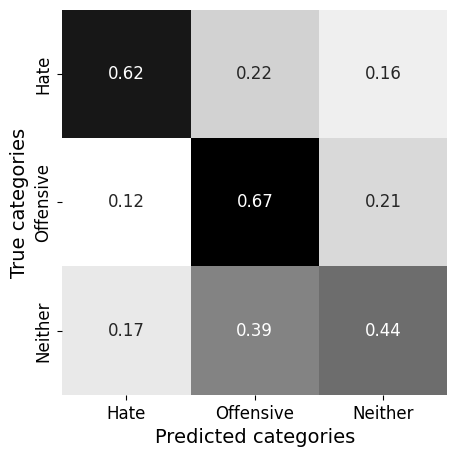

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as seaborn

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

<Axes: >

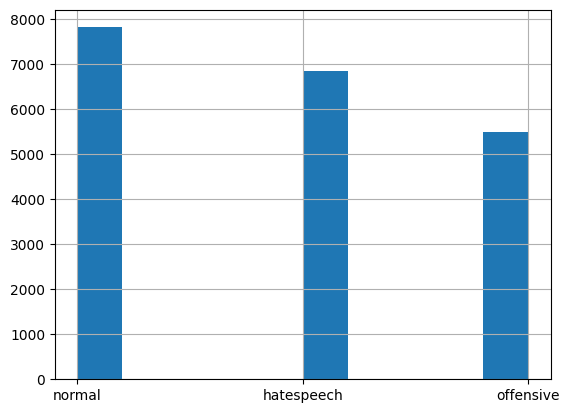

In [ ]:
#True distribution
y.hist()

<Axes: >

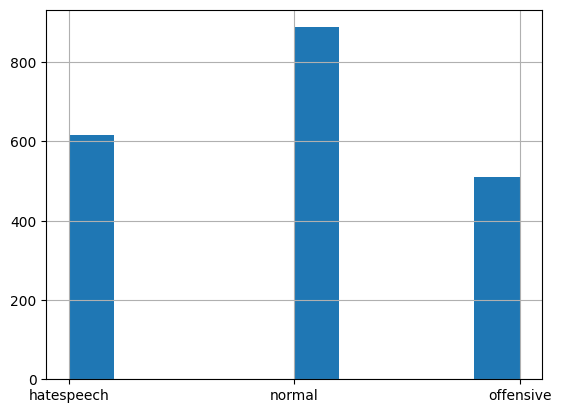

In [ ]:
pd.Series(y_preds).hist()

**3.3.5 Discussion: Model 2 VS Model 3**

**Feature selection method:**

Model 2 uses SelectFromModel combined with a logistic regression model with l2 regularization. This approach tends to keep more features but shrinks the coefficients of the features. The property of l2 regularization is that it does not completely change the coefficients of some features to zero, so the selected features may contain some features with weak correlation.

Model 3 uses SelectFromModel combined with a logistic regression model with l1 regularization. l1 regularization has the property of producing a sparse model, that is, it can change the coefficients of some unimportant features to zero, thus selecting a more compact feature set. This feature selection method may improve the generalization ability of the model because it reduces the complexity of the model.

**Classifier:**

Model 2 uses LinearSVC (Linear support vector Machine classifier). SVC has different assumptions and decision boundaries for classification tasks, which may lead to different classification results than logistic regression.

Model 3 continues to use LogisticRegression as the classifier, and this consistency may lead to different decision boundaries and classification results.

**Pipeline and hyperparameter tuning:**

No pipeline or hyperparameter tuning was used in Model 2, meaning that the setting of the model was fixed and the performance of the model was not further optimized.

Model 3 uses pipelines and GridSearchCV for hyperparameter tuning, and even though param_grid is currently empty, this setting provides structure to optimize the model in the future. This optimization process can often improve the accuracy of the model by finding the optimal combination of parameters.

**The analysis results of Model 2 and Model 3**

The high accuracy of model 2 may result from its better performance in feature selection, parameter configuration, and data adaptation. The feature selection and regularization of Model 3 may be too aggressive, resulting in the loss of some valuable features or information. Therefore, the performance of the model depends on the level of detail of the feature engineering, the complexity of the model, and the specific properties of the dataset. To further optimize the model, it may be necessary to adjust the feature selection strategy, extend the scope of hyperparameter tuning, or reevaluate the fit of the model structure.

**4. Discussion**

**4.1 Bert + CNN Model:**

**Strengths:**
- Bert+CNN combines the contextual understanding of BERT with the feature extraction capabilities of CNN.
- Demonstrated relatively balanced performance across datasets, especially strong in recall for class 2 (0.78).

**Weaknesses:**
- Lower precision and recall for class 1, indicating difficulties in accurately identifying this class.
- Performance is dataset-dependent, with some metrics showing significant variation.

**Limitations:**
- The model is complex and has a high computational cost.

**4.2 Comprehensive Feature Model (CFM):**
**Strengths:**
- High precision and recall across multiple classes, particularly in normal and hate categories.
- Robust performance on Dataset 1 with good macro and weighted averages.

**Weaknesses:**
- Lower performance in offensive category (class 2) as indicated by lower precision and recall.

**Limitations:**
- This model may lead to overfitting on smaller datasets.

**4.3 Streamlined Classifier Model (SCM):**

**Strengths:**
- Simplicity in implementation and lower computational requirements.
- Balanced performance in normal and hate categories.

**Weaknesses:**
- Struggles significantly with the offensive category (class 2) with the lowest F1-score among models.
- Overall lower performance metrics compared to the other models.

**Limitations:**
- It lacks generalization ability and cannot distinguish subtle differences in complex texts.

**4.4 Possible Future Work:**
- **Model Ensemble:** Combining the strengths of Bert+CNN and CFM to create an ensemble model that leverages the high recall of Bert+CNN with the precision of CFM.

- **Advanced Preprocessing:** Implementing more sophisticated preprocessing techniques to handle nuances in text data better.

- **Hyperparameter Tuning:** Conducting extensive hyperparameter tuning to optimize model performance.

- **Cross-Dataset Evaluation:** Testing models on more diverse datasets to ensure generalizability and robustness.

- **Real-time Implementation:** Exploring the feasibility of deploying these models in real-time environments for proactive hate speech detection.